In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Data loading and test train split 

In [2]:
import torch
from torch import nn
from transformers import RobertaModel, RobertaTokenizer
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob



In [3]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
pip install torch transformers datasets


Note: you may need to restart the kernel to use updated packages.


In [4]:
df=pd.read_csv('/kaggle/input/anlp-pj-1/Headlines.csv')

In [5]:
df['label'].value_counts()

label
nonsarcastic    14985
sarcastic       11724
Name: count, dtype: int64

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv('/kaggle/input/anlp-pj-1/Headlines.csv')

# Split the dataset into training (70%), validation (20%), and test (10%)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)  # 70% training, 30% temp
val_df, test_df = train_test_split(temp_df, test_size=0.33, random_state=42)  # 20% validation, 10% test

# Print the sizes of the splits
print(f'Training set: {len(train_df)} samples')
print(f'Validation set: {len(val_df)} samples')
print(f'Test set: {len(test_df)} samples')

# # Optional: Save the splits to CSV files
# train_df.to_csv('train_set.csv', index=False)
# val_df.to_csv('val_set.csv', index=False)
# test_df.to_csv('test_set.csv', index=False)


Training set: 18696 samples
Validation set: 5368 samples
Test set: 2645 samples


## Data Analysis

In [4]:
train_df.head()

,label,headline,valid
5874,nonsarcastic,interview: director david dobkin on the judge,False
15611,sarcastic,gas station clerk glad to see pump 2 doing so ...,False
5303,sarcastic,amazing 'human fly' lives off diet of garbage,False
2703,nonsarcastic,issa rae's unapologetic support of black stars...,False
6586,sarcastic,secretary masks deep depression with laughter ...,False


###  Class distribution

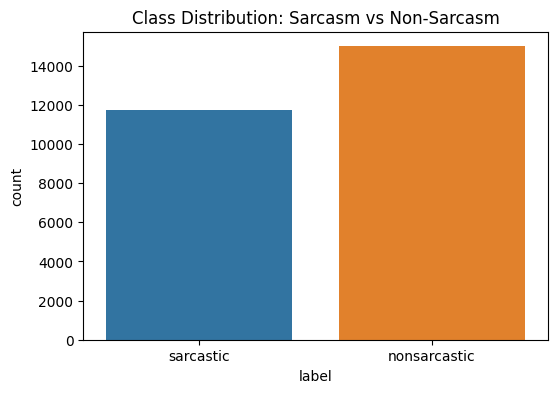

In [5]:
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df)
plt.title("Class Distribution: Sarcasm vs Non-Sarcasm")
plt.show()

### Text Length Distribution

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


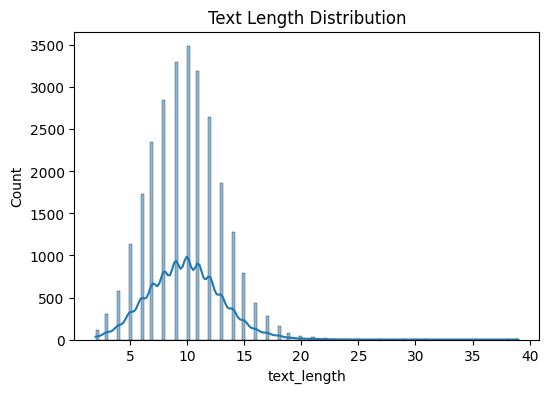

In [7]:
df['text_length'] = df['headline'].apply(lambda x: len(x.split()))
plt.figure(figsize=(6,4))
sns.histplot(df['text_length'], kde=True)
plt.title('Text Length Distribution')
plt.show()

### Text Preprocessing: Punctuation and Special Symbols

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

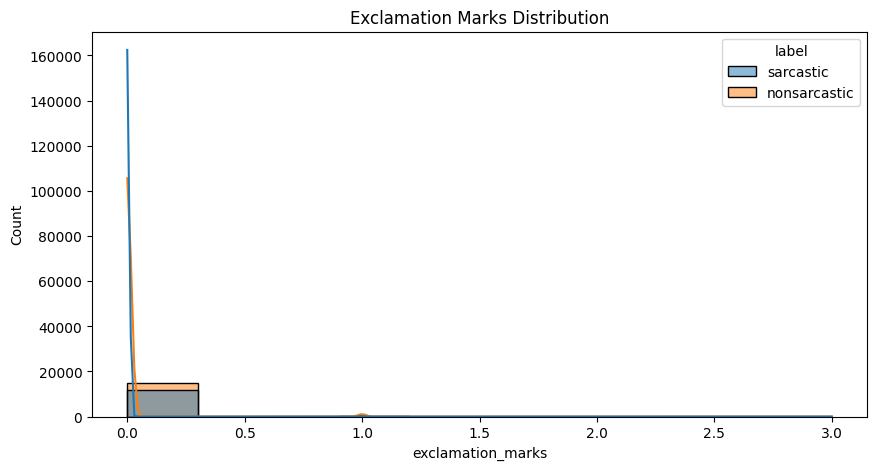

In [8]:
df['exclamation_marks'] = df['headline'].apply(lambda x: x.count('!'))
df['question_marks'] = df['headline'].apply(lambda x: x.count('?'))

plt.figure(figsize=(10,5))
sns.histplot(data=df, x='exclamation_marks', hue='label', bins=10, kde=True)
plt.title('Exclamation Marks Distribution')
plt.show()


### Hashtags and Emojis

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

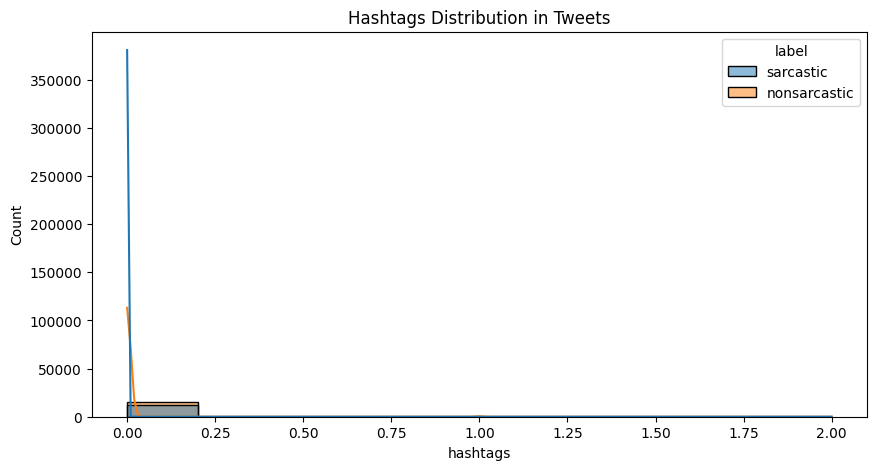

In [10]:
df['hashtags'] = df['headline'].apply(lambda x: len([word for word in x.split() if word.startswith('#')]))
df['emoji'] = df['headline'].apply(lambda x: len([c for c in x if c in '😂🙄😒🙃😏']))

plt.figure(figsize=(10,5))
sns.histplot(data=df, x='hashtags', hue='label', bins=10, kde=True)
plt.title('Hashtags Distribution in Tweets')
plt.show()

### Lexical Analysis: Word Frequency and N-grams
### Most common words for sarcastic and non-sarcastic texts

In [23]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

# Ensure stopwords are downloaded
stop_words = list(stopwords.words('english'))  # Convert set to list

def get_most_common_words(text_series, n=20):
    vectorizer = CountVectorizer(stop_words=stop_words)
    word_count = vectorizer.fit_transform(text_series)
    word_freq = word_count.sum(axis=0).A1
    words = vectorizer.get_feature_names_out()
    word_freq_df = pd.DataFrame(list(zip(words, word_freq)), columns=['word', 'frequency'])
    return word_freq_df.sort_values(by='frequency', ascending=False).head(n)

# Filter sarcastic and non-sarcastic texts based on the label
sarcastic_texts = df[df['label'].str.lower() == 'sarcastic']['headline']  # Ensures the label match is case insensitive
common_words_sarcastic = get_most_common_words(sarcastic_texts)
print("Most Common Words in Sarcastic Texts")
print(common_words_sarcastic)

non_sarcastic_texts = df[df['label'].str.lower() == 'nonsarcastic']['headline']  # Ensures the label match is case insensitive
common_words_non_sarcastic = get_most_common_words(non_sarcastic_texts)
print("Most Common Words in Non-Sarcastic Texts")
print(common_words_non_sarcastic)


Most Common Words in Sarcastic Texts
         word  frequency
9368      man       1154
10379     new        843
1007     area        480
12822  report        426
10270  nation        339
17128   woman        319
17253    year        308
10707     one        273
10682     old        267
15657    time        252
4043      day        245
16009   trump        238
14959   study        213
14805   still        212
8998     like        194
5995    first        193
6583      get        190
1310     back        189
5739   family        186
10579   obama        185
Most Common Words in Non-Sarcastic Texts
          word  frequency
15992    trump       1446
10496      new        680
4699    donald        458
13524     says        349
17080    women        317
10856      one        268
17214     year        244
5938     first        242
9386       man        241
17116    world        241
11365   people        241
10737    obama        235
4017       day        226
9355      make        217
6646   

# 4. Sentiment and Subjectivity Analysis

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

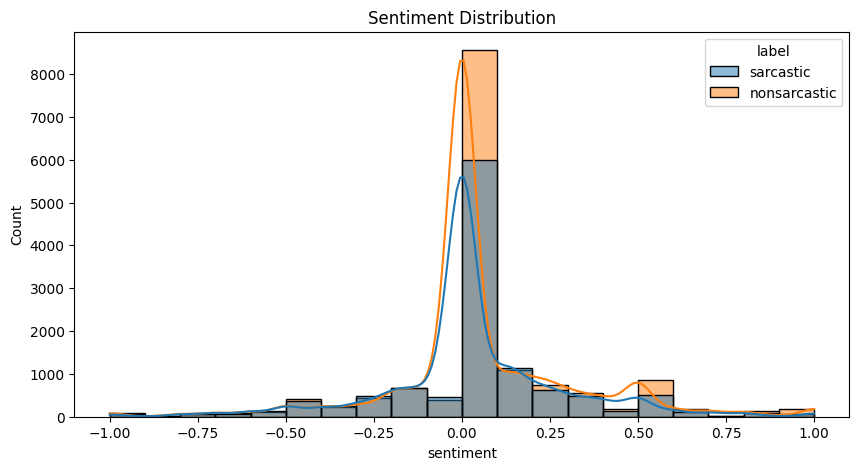

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

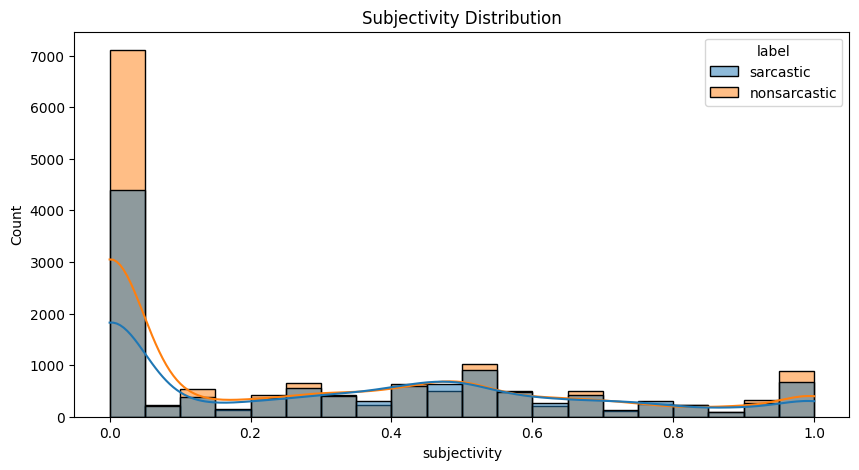

In [14]:
def analyze_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

df['sentiment'] = df['headline'].apply(lambda x: analyze_sentiment(x)[0])
df['subjectivity'] = df['headline'].apply(lambda x: analyze_sentiment(x)[1])

plt.figure(figsize=(10,5))
sns.histplot(data=df, x='sentiment', hue='label', bins=20, kde=True)
plt.title('Sentiment Distribution')
plt.show()

plt.figure(figsize=(10,5))
sns.histplot(data=df, x='subjectivity', hue='label', bins=20, kde=True)
plt.title('Subjectivity Distribution')
plt.show()

### 5. POS Tagging Analysis

In [17]:
def pos_tagging(text):
    tokens = word_tokenize(text)
    return pos_tag(tokens)

df['pos_tags'] = df['headline'].apply(pos_tagging)

# Count parts of speech
def count_pos_tags(pos_tagged_text, pos_tag):
    return len([tag for word, tag in pos_tagged_text if tag.startswith(pos_tag)])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

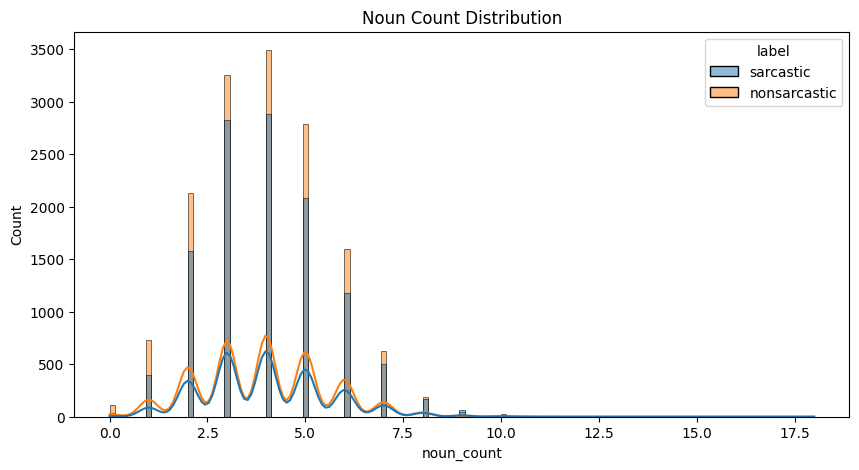

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

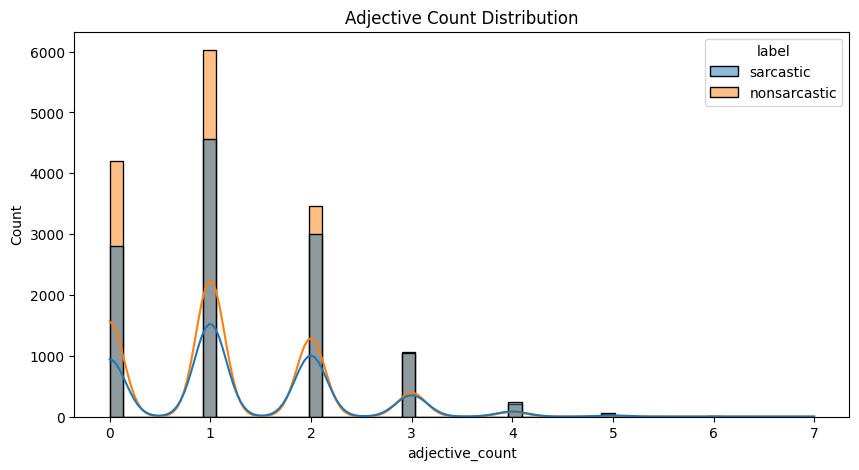

In [18]:
df['noun_count'] = df['pos_tags'].apply(lambda x: count_pos_tags(x, 'NN'))
df['adjective_count'] = df['pos_tags'].apply(lambda x: count_pos_tags(x, 'JJ'))

plt.figure(figsize=(10,5))
sns.histplot(data=df, x='noun_count', hue='label', kde=True)
plt.title('Noun Count Distribution')
plt.show()

plt.figure(figsize=(10,5))
sns.histplot(data=df, x='adjective_count', hue='label', kde=True)
plt.title('Adjective Count Distribution')
plt.show()

### Word Cloud Visualization

In [24]:
sarcastic_text = " ".join(text for text in sarcastic_texts)
non_sarcastic_text = " ".join(text for text in non_sarcastic_texts)

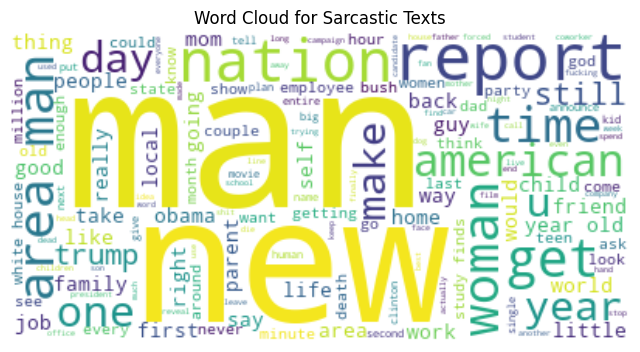

In [25]:
wordcloud = WordCloud(stopwords=stop_words, background_color="white").generate(sarcastic_text)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Sarcastic Texts")
plt.show()

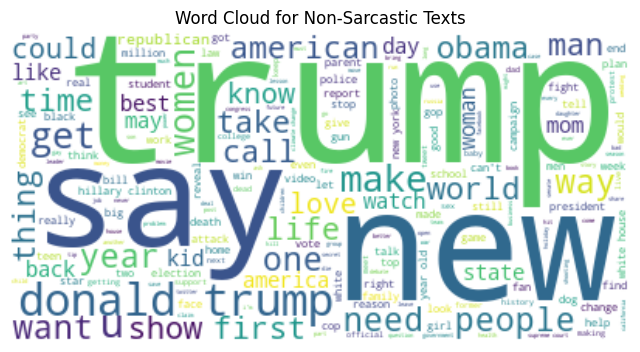

In [26]:
wordcloud = WordCloud(stopwords=stop_words, background_color="white").generate(non_sarcastic_text)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Non-Sarcastic Texts")
plt.show()

## Creating Dataloaders

In [2]:
pip install allennlp


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.2/248.2 kB 9.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.2/594.2 kB 27.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.2/730.2 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 8

In [7]:
class SarcasmDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            max_length=self.max_len,
            add_special_tokens=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Load dataset
df['label'] = df['label'].apply(lambda x: 1 if x == 'sarcastic' else 0)
texts = df['headline'].values
labels = df['label'].values

# Split into train, validation, and test sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(texts, labels, test_size=0.3, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.33, random_state=42)

# Initialize the tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Create datasets
train_dataset = SarcasmDataset(train_texts, train_labels, tokenizer, max_len=128)
val_dataset = SarcasmDataset(val_texts, val_labels, tokenizer, max_len=128)
test_dataset = SarcasmDataset(test_texts, test_labels, tokenizer, max_len=128)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## Elmo

In [6]:
import torch
import torch.nn as nn
from allennlp.modules.elmo import Elmo, batch_to_ids

class ELMoSarcasmDetector(nn.Module):
    def __init__(self, elmo_options_file, elmo_weight_file, hidden_dim=128, output_dim=2, dropout=0.3):
        super(ELMoSarcasmDetector, self).__init__()
        

        self.elmo = Elmo(elmo_options_file, elmo_weight_file, 1, dropout=0)

        self.lstm = nn.LSTM(1024, hidden_dim, batch_first=True, bidirectional=True)

        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        

        self.dropout = nn.Dropout(dropout)
        
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, sentence_character_ids):
        # Get the ELMo embeddings
        elmo_output = self.elmo(sentence_character_ids)
        elmo_embeddings = elmo_output['elmo_representations'][0]  # Shape: [batch_size, seq_len, 1024]
        
        # Pass the embeddings through the LSTM
        lstm_output, _ = self.lstm(elmo_embeddings)  # Shape: [batch_size, seq_len, hidden_dim*2]
        
        # Global Max Pooling to get the most important features
        pooled_output = torch.max(lstm_output, dim=1)[0]  # Shape: [batch_size, hidden_dim*2]
        
        # Fully connected layer
        output = self.fc(self.dropout(pooled_output))  # Shape: [batch_size, output_dim]
        
        # Apply softmax to get probabilities
        output = self.softmax(output)
        
        return output

In [9]:
def collate_fn(batch):
    sentences = [item[0] for item in batch]
    labels = torch.tensor([item[1] for item in batch])
    
    # Pad sentences dynamically
    max_len = max([s.size(0) for s in sentences])
    padded_sentences = torch.zeros((len(sentences), max_len, sentences[0].size(1))).long()
    
    for i, s in enumerate(sentences):
        padded_sentences[i, :s.size(0), :] = s
        
    return padded_sentences, labels

In [10]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    model = model.to(device)
    for epoch in range(num_epochs):
        model.train()
        total_loss, total_correct = 0, 0

        # Training loop
        for batch in train_loader:
            sentences, labels = batch
            sentences, labels = sentences.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(sentences)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_correct += (outputs.argmax(dim=1) == labels).sum().item()

        avg_loss = total_loss / len(train_loader)
        accuracy = total_correct / len(train_loader.dataset)
        print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

        # Validation loop
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for batch in val_loader:
                sentences, labels = batch
                sentences, labels = sentences.to(device), labels.to(device)

                outputs = model(sentences)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_correct += (outputs.argmax(dim=1) == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = val_correct / len(val_loader.dataset)
        print(f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

In [17]:
import torch.optim as optim
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from allennlp.modules.elmo import batch_to_ids

In [19]:
import torch
print(torch.__version__)


2.4.0


In [18]:
elmo_options_file = "/kaggle/input/elmo-pretrained-option-files-for-nlp/elmo_2x4096_512_2048cnn_2xhighway_options.json"
elmo_weight_file = "/kaggle/input/elmo-pretrained-weights-for-nlp/elmo_2x4096_512_2048cnn_2xhighway_weights.hdf5"
batch_size = 32
learning_rate = 1e-3
num_epochs = 10
hidden_dim = 128
output_dim = 2
dropout = 0.3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ELMoSarcasmDetector(elmo_options_file, elmo_weight_file, hidden_dim=hidden_dim, output_dim=output_dim, dropout=dropout)
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train(model, train_data_loader, val_data_loader, criterion, optimizer, num_epochs=num_epochs, device='cuda')

ModuleNotFoundError: No module named 'torch._dynamo'

In [ ]:
import torch
import torch.nn as nn
from allennlp.modules.elmo import Elmo, batch_to_ids

class ELMoSarcasmDetector(nn.Module):
    def __init__(self, elmo_options_file, elmo_weight_file, hidden_dim=128, output_dim=2, dropout=0.3):
        super(ELMoSarcasmDetector, self).__init__()
        
        # ELMo embeddings
        self.elmo = Elmo(elmo_options_file, elmo_weight_file, 1, dropout=0)
        
        # LSTM layer to handle the sequential nature of the embeddings
        self.lstm = nn.LSTM(1024, hidden_dim, batch_first=True, bidirectional=True)
        
        # Fully connected layer for classification
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)
        
        # Softmax for classification
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, sentence_character_ids):
        # Get the ELMo embeddings
        elmo_output = self.elmo(sentence_character_ids)
        elmo_embeddings = elmo_output['elmo_representations'][0]  # Shape: [batch_size, seq_len, 1024]
        
        # Pass the embeddings through the LSTM
        lstm_output, _ = self.lstm(elmo_embeddings)  # Shape: [batch_size, seq_len, hidden_dim*2]
        
        # Global Max Pooling to get the most important features
        pooled_output = torch.max(lstm_output, dim=1)[0]  # Shape: [batch_size, hidden_dim*2]
        
        # Fully connected layer
        output = self.fc(self.dropout(pooled_output))  # Shape: [batch_size, output_dim]
        
        # Apply softmax to get probabilities
        output = self.softmax(output)
        
        return output

# Example usage
# if __name__ == "__main__":
    # ELMo model files (pre-trained)
    elmo_options_file = "https://allennlp.s3.amazonaws.com/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_options.json"
    elmo_weight_file = "https://allennlp.s3.amazonaws.com/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_weights.hdf5"
    
    # Initialize the model
    model = ELMoSarcasmDetector(elmo_options_file, elmo_weight_file)
    
    # Sample input (a batch of sentences in character ID format)
    sentences = ["This is so great!", "Oh, wonderful, another Monday..."]
    
    # Convert words to character IDs
    character_ids = batch_to_ids([sentence.split() for sentence in sentences])  # Shape: [batch_size, seq_len, char_len]
    
    # Forward pass
    output = model(character_ids)
    
    print(output)


## RCNNRoberta

In [8]:
class RCNNRobertaModel(nn.Module):
    def __init__(self, num_labels):
        super(RCNNRobertaModel, self).__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.lstm = nn.LSTM(768, 64, bidirectional=True, batch_first=True)
        self.conv1d = nn.Conv1d(128, 64, kernel_size=3, padding=1)
        self.fc = nn.Linear(64, num_labels)
        self.dropout = nn.Dropout(0.1)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state  # (batch_size, seq_len, 768)
        
        lstm_output, _ = self.lstm(last_hidden_state)  # (batch_size, seq_len, 128)
        lstm_output = lstm_output.permute(0, 2, 1)  # Change shape for Conv1D (batch_size, 128, seq_len)

        conv_output = torch.relu(self.conv1d(lstm_output))  # (batch_size, 64, seq_len)
        pooled_output = torch.max(conv_output, dim=2)[0]  # Max pooling

        pooled_output = self.dropout(pooled_output)
        logits = self.fc(pooled_output)

        return logits


In [11]:
from torch.optim.lr_scheduler import StepLR

# Define the learning rate scheduler


# Modify the train loop to use the scheduler
def train_model(model, train_data_loader, val_data_loader, epochs, device, optimizer, scheduler, loss_fn):
    model = model.to(device)
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for batch in train_data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_data_loader)
        print(f'Epoch {epoch+1}, Loss: {avg_loss}')

        # Validation loop
        val_accuracy, val_f1 = eval_model(model, val_data_loader, device)
        print(f'Validation Accuracy: {val_accuracy}, F1 Score: {val_f1}')


In [13]:
def eval_model(model, val_data_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in val_data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')
    
    return accuracy, f1


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RCNNRobertaModel(num_labels=2)  # Binary classification for sarcasm
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, eps=1e-6)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)
loss_fn = nn.CrossEntropyLoss()

# Create DataLoader instances for train, validation, and test sets
train_data_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=16)

epochs = 10
train_model(model, train_data_loader, val_data_loader, epochs, device, optimizer, scheduler, loss_fn)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Loss: 0.6886315287128282
Validation Accuracy: 0.5666915052160953, F1 Score: 0.40995851578296366
Epoch 2, Loss: 0.6885949833154474
Validation Accuracy: 0.5666915052160953, F1 Score: 0.40995851578296366
Epoch 3, Loss: 0.6888644374569223
Validation Accuracy: 0.5666915052160953, F1 Score: 0.40995851578296366
Epoch 4, Loss: 0.6886368387779483
Validation Accuracy: 0.5666915052160953, F1 Score: 0.40995851578296366
Epoch 5, Loss: 0.6885164968471837
Validation Accuracy: 0.5666915052160953, F1 Score: 0.40995851578296366
Epoch 6, Loss: 0.6886633454580608
Validation Accuracy: 0.5666915052160953, F1 Score: 0.40995851578296366
Epoch 7, Loss: 0.6887115731618667
Validation Accuracy: 0.5666915052160953, F1 Score: 0.40995851578296366
Epoch 8, Loss: 0.6886341244466698
Validation Accuracy: 0.5666915052160953, F1 Score: 0.40995851578296366
Epoch 9, Loss: 0.6887964797489046
Validation Accuracy: 0.5666915052160953, F1 Score: 0.40995851578296366
Epoch 10, Loss: 0.6887013226416092
Validation Accuracy:

In [ ]:
# class RCNNRobertaModel(nn.Module):
#     def __init__(self, num_labels):
#         super(RCNNRobertaModel, self).__init__()
#         self.roberta = RobertaModel.from_pretrained('roberta-base')
#         self.lstm = nn.LSTM(768, 64, bidirectional=True, batch_first=True)
#         self.conv1d = nn.Conv1d(128, 64, kernel_size=3, padding=1)
#         self.fc = nn.Linear(64, num_labels)
#         self.dropout = nn.Dropout(0.1)

#     def forward(self, input_ids, attention_mask):
#         with torch.no_grad():
#             outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
#         last_hidden_state = outputs.last_hidden_state  # (batch_size, seq_len, 768)
        
#         lstm_output, _ = self.lstm(last_hidden_state)  # (batch_size, seq_len, 128)
#         lstm_output = lstm_output.permute(0, 2, 1)  # Change shape for Conv1D (batch_size, 128, seq_len)

#         conv_output = torch.relu(self.conv1d(lstm_output))  # (batch_size, 64, seq_len)
#         pooled_output = torch.max(conv_output, dim=2)[0]  # Max pooling

#         pooled_output = self.dropout(pooled_output)
#         logits = self.fc(pooled_output)

#         return logits


In [13]:
# import pandas as pd

# # Specify the file path
# # file_path = '/kaggle/input/semeval-2018-task-ec/2018-E-c-En-dev.txt'

# # Read the file into a DataFrame
# # df_train = pd.read_csv("/kaggle/input/semeval-2018-task-ec/2018-E-c-En-train.txt", delimiter='\t')
# # df_test = pd.read_csv("/kaggle/input/semeval-2018-task-ec/2018-E-c-En-test.txt", delimiter='\t')
# # df_dev = pd.read_csv("/kaggle/input/semeval-2018-task-ec/2018-E-c-En-dev.txt", delimiter='\t')
# # Display the DataFrame
# print(df)


                ID                                              Tweet  anger  \
0    2018-En-00866  @RanaAyyub @rajnathsingh Oh, hidden revenge an...      1   
1    2018-En-02590  I'm doing all this to make sure you smiling do...      0   
2    2018-En-03361  if not then #teamchristine bc all tana has don...      1   
3    2018-En-03230  It is a #great start for #beginners to jump in...      0   
4    2018-En-01143  My best friends driving for the first time wit...      0   
..             ...                                                ...    ...   
881  2018-En-01993  @BadHombreNPS @SecretaryPerry If this didn't m...      1   
882  2018-En-01784  Excited to watch #stateoforigin tonight! Come ...      0   
883  2018-En-04047  Blah blah blah Kyrie, IT, etc. @CJC9BOSS leavi...      1   
884  2018-En-03041  #ThingsIveLearned The wise #shepherd never tru...      0   
885  2018-En-03386  I am really flattered and happy to hear those ...      0   

     anticipation  disgust  fear  joy  

In [14]:
# df_train.columns

Index(['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy',
       'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
      dtype='object')

In [11]:

# model = RCNNRoberta()
# # texts = ["I love this!", "Oh, great, another rainy /day..."]

# # Preprocess text (tokenize)
# inputs = preprocess_text(df['Tweet'], tokenizer)

# # Forward pass through the model
# output = model(inputs['input_ids'], inputs['attention_mask'])

# print(output)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).